# Use emcee to sample Lya posterior as a function of mean flux

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import cProfile
import emcee
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import mf_emulator
import data_PD2013
import data_MPGADGET
import lya_theory
import likelihood

## Setup Lya likelihood function

In [2]:
# read P1D measurement
#data=data_PD2013.P1D_PD2013(blind_data=True)
#data=data_PD2013.P1D_PD2013(blind_data=True,zmin=2.1,zmax=4.7)
data=data_MPGADGET.P1D_MPGADGET(filename="1024_L90_mimic.json",z_list=[2.0,3.0,4.0])
zs=data.z

In [3]:
#basedir='../../p1d_emulator/sim_suites/emulator_512_18062019/'
#basedir='../../p1d_emulator/sim_suites/emulator_512_17052019/'
basedir='../../p1d_emulator/sim_suites/emulator_256_15072019/'
kmax_Mpc=4.0
p1d_label=None
skewers_label='Ns256_wM0.05'
undersample_z=1
max_arxiv_size=2000
paramList=["Delta2_p","n_p","mF","sigT_Mpc","gamma","kF_Mpc"]
emu_type='mf'
if emu_type=='polyfit':
    emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                undersample_z=undersample_z,max_arxiv_size=max_arxiv_size,emu_type=emu_type,
                                kmax_Mpc=kmax_Mpc,verbose=False,paramList=paramList,train=True)
elif emu_type=='k_bin':
    emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                               undersample_z=undersample_z,max_arxiv_size=max_arxiv_size,
                               verbose=False,paramList=paramList,train=True,emu_type=emu_type)
elif emu_type=='linear':
    # specify parameters to emulate
    emulate_slope=False
    emulate_growth=False
    emulate_running=False
    emulate_pressure=True
    emu=linear_emulator.LinearEmulator(basedir,p1d_label,skewers_label,kmax_Mpc=kmax_Mpc,
                                undersample_z=undersample_z,max_arxiv_size=max_arxiv_size,
                                emulate_slope=emulate_slope,emulate_running=emulate_running,
                                emulate_pressure=emulate_pressure,emulate_growth=emulate_growth,verbose=False)
elif emu_type=='NGP':
    emu=simplest_emulator.SimplestEmulator(basedir,p1d_label,skewers_label,
                                undersample_z=undersample_z,max_arxiv_size=max_arxiv_size,
                                verbose=False)
elif emu_type=='mf':
    emu=mf_emulator.MeanFluxEmulator(basedir,p1d_label,skewers_label,
                                kmax_Mpc=kmax_Mpc,emu_type='k_bin',
                                max_arxiv_size=None,
                                verbose=True,paramList=paramList,train=True)
else:
    raise ValueError('wrong emulator type '+emu_type)

0 0.05 0.0 <mf< 0.15000000000000002
1 0.15 0.04999999999999999 <mf< 0.25
2 0.25 0.15 <mf< 0.35
3 0.35 0.24999999999999997 <mf< 0.44999999999999996
4 0.44999999999999996 0.35 <mf< 0.5499999999999999
5 0.5499999999999999 0.44999999999999996 <mf< 0.6499999999999999
6 0.65 0.55 <mf< 0.75
7 0.75 0.65 <mf< 0.85
8 0.85 0.75 <mf< 0.95
9 0.95 0.85 <mf< 1.0
latin hyper-cube data {'param_space': {'Delta2_star': {'ip': 0, 'min_val': 0.25, 'max_val': 0.45, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\Delta^2_\\star$'}, 'n_star': {'ip': 1, 'min_val': -2.35, 'max_val': -2.25, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$n_\\star$'}, 'heat_amp': {'ip': 2, 'min_val': 0.3, 'max_val': 3.0, 'latex': '$H_A$'}, 'heat_slo': {'ip': 3, 'min_val': -1.5, 'max_val': 1.5, 'latex': '$H_S$'}, 'z_rei': {'ip': 4, 'min_val': 5.5, 'max_val': 16.0, 'latex': '$z_r$'}}, 'nsamples': 50, 'samples': {'0': [0.392, -2.319, 2.757, -0.4500000000000002, 11.905000000000001], '1': [0.268, -2.327, 1.0830000000000002, -1.41, 6.025], '2': [0

 /Users/font/Programs/Others/anaconda3/lib/python3.6/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


6750 initial entries
use 353/6750 entries
build emulator 1/10, <F>=0.150
Loading emulator using a specific arxiv, not the one set in basedir
Rescaled params to unity volume
Cannot load emulators with non-standard training data
will train GP emulator
Training GP on 353 points
Optimised
6750 initial entries
use 859/6750 entries
build emulator 2/10, <F>=0.250
Loading emulator using a specific arxiv, not the one set in basedir
Rescaled params to unity volume
Cannot load emulators with non-standard training data
will train GP emulator
Training GP on 859 points
Optimised
6750 initial entries
use 1221/6750 entries
build emulator 3/10, <F>=0.350
Loading emulator using a specific arxiv, not the one set in basedir
Rescaled params to unity volume
Cannot load emulators with non-standard training data
will train GP emulator
Training GP on 1221 points
Optimised
6750 initial entries
use 1409/6750 entries
build emulator 4/10, <F>=0.450
Loading emulator using a specific arxiv, not the one set in basedi

In [4]:
# setup theory to predict Lya 1D power
#theory=lya_theory.LyaTheory(zs,emulator=emu,verbose=True)
theory=lya_theory.get_mock_theory(zs,emulator=emu,verbose=True)

Note: redshifts have been re-sorted (earliest first)


In [5]:
# specify free parameters in likelihood
free_parameters=['ln_tau_0']
min_kp_kms=0.003
prior_Gauss_rms=0.05
# ignore emulator covariance for now
ignore_emu_cov=True
like=likelihood.Likelihood(data=data,theory=theory,free_parameters=free_parameters,
                           min_kp_kms=min_kp_kms,ignore_emu_cov=ignore_emu_cov,
                           prior_Gauss_rms=prior_Gauss_rms,verbose=True)

got parameters
g_star = 0.9677508579459803
f_star = 0.981369557840318
Delta2_star = 0.36017590528641974
n_star = -2.299335667257498
alpha_star = -0.2165270371206895
ln_tau_0 = -1.03436530241446
ln_tau_1 = 3.6744666006830182
T0_1 = 0.13626544653787526
T0_2 = 9.546039892898634
T0_3 = -1.2041429220366868
ln_gamma_0 = 0.3295042060454974
ln_gamma_1 = -0.2521703939255174
ln_kF_0 = -0.8077668277205104
ln_kF_1 = 1.9001923998886694
likelihood setup with 1 free parameters
1 free parameters


In [6]:
for p in like.free_params:
    print(p.name,p.value)

ln_tau_0 -1.03436530241446


0 2.0000000300000003 model {'Delta2_p': 0.6300728199380837, 'n_p': -2.2994793220516994, 'alpha_p': -0.2163759661951201, 'f_p': 0.9583552547543478, 'mF': 0.8800056787533069, 'gamma': 1.5485096141904715, 'sigT_Mpc': 0.15238550478390972, 'kF_Mpc': 14.00185605911427}
1 3.0 model {'Delta2_p': 0.36031650137680626, 'n_p': -2.2994794594828254, 'alpha_p': -0.21637600594737977, 'f_p': 0.9813695511850136, 'mF': 0.6922006275553464, 'gamma': 1.4401510877175236, 'sigT_Mpc': 0.13864693323079097, 'kF_Mpc': 27.32902922574384}
2 4.0 model {'Delta2_p': 0.23205325295753354, 'n_p': -2.299479861066885, 'alpha_p': -0.216376343226051, 'f_p': 0.9898232760729386, 'mF': 0.43378134296642873, 'gamma': 1.361351331965516, 'sigT_Mpc': 0.11877445527906401, 'kF_Mpc': 46.32385039803334}
asked to emulate model {'Delta2_p': 0.6300728199380837, 'n_p': -2.2994793220516994, 'alpha_p': -0.2163759661951201, 'f_p': 0.9583552547543478, 'mF': 0.8800056787533069, 'gamma': 1.5485096141904715, 'sigT_Mpc': 0.15238550478390972, 'kF_Mp

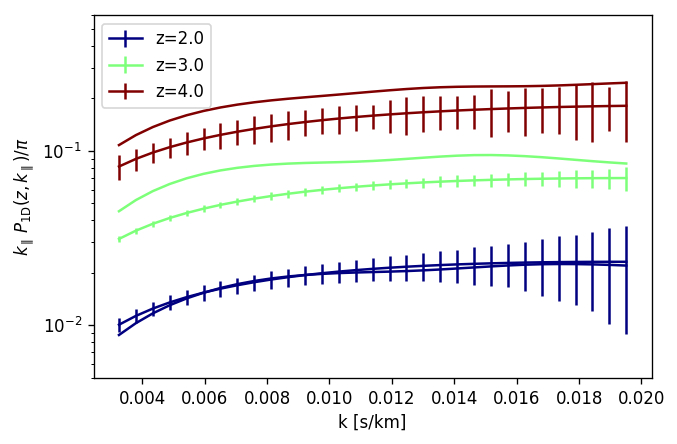

0 2.0000000300000003 model {'Delta2_p': 0.6300728199380837, 'n_p': -2.2994793220516994, 'alpha_p': -0.2163759661951201, 'f_p': 0.9583552547543478, 'mF': 0.8800056787533069, 'gamma': 1.5485096141904715, 'sigT_Mpc': 0.15238550478390972, 'kF_Mpc': 14.00185605911427}
1 3.0 model {'Delta2_p': 0.36031650137680626, 'n_p': -2.2994794594828254, 'alpha_p': -0.21637600594737977, 'f_p': 0.9813695511850136, 'mF': 0.6922006275553464, 'gamma': 1.4401510877175236, 'sigT_Mpc': 0.13864693323079097, 'kF_Mpc': 27.32902922574384}
2 4.0 model {'Delta2_p': 0.23205325295753354, 'n_p': -2.299479861066885, 'alpha_p': -0.216376343226051, 'f_p': 0.9898232760729386, 'mF': 0.43378134296642873, 'gamma': 1.361351331965516, 'sigT_Mpc': 0.11877445527906401, 'kF_Mpc': 46.32385039803334}
asked to emulate model {'Delta2_p': 0.6300728199380837, 'n_p': -2.2994793220516994, 'alpha_p': -0.2163759661951201, 'f_p': 0.9583552547543478, 'mF': 0.8800056787533069, 'gamma': 1.5485096141904715, 'sigT_Mpc': 0.15238550478390972, 'kF_Mp

-2303.2155089488697

In [7]:
# test likelihood function
values=[0.5]
like.plot_p1d(values=values,plot_every_iz=1)
like.log_prob(values=values)

In [8]:
#cProfile.run("like.log_prob(values=values,linP_Mpc_params=linP_Mpc_params)",sort='cumtime')

### Setup function to be called in MCMC

In [9]:
like.go_silent()

In [10]:
xs=np.linspace(0.0,1.0,100)
xmin=like.free_params[0].min_value
xmax=like.free_params[0].max_value
print(xmin,'< ln_tau_0 <',xmax)
print(np.exp(xmin),'< tau_0 <',np.exp(xmax))
print(np.exp(-np.exp(xmax)),'< <F> <',np.exp(-np.exp(xmin)))
mf=np.exp(-np.exp(xmin+xs*(xmax-xmin)))
lnps=[like.log_prob([x]) for x in xs]

-1.5 < ln_tau_0 < -0.5
0.22313016014842982 < tau_0 < 0.6065306597126334
0.545239211892605 < <F> < 0.8000107130043536


Text(0, 0.5, '$\\chi^2$')

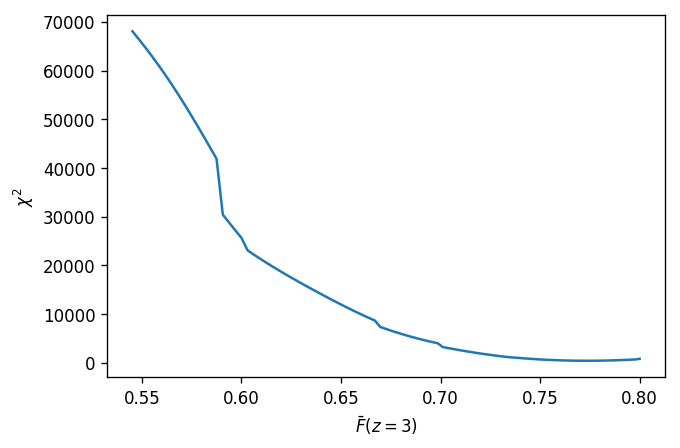

In [11]:
plt.plot(mf,-2.0*np.array(lnps))
plt.xlabel(r'$\bar F(z=3)$')
plt.ylabel(r'$\chi^2$')

### Setup MCMC

In [12]:
# for now we'll have only one dimension (mean flux amplitude)
ndim=1
# setup initial walkers
nwalkers = 10
p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))

In [13]:
p0.flatten()

array([0.59859742, 0.34212337, 0.67790497, 0.56685142, 0.87765028,
       0.92050651, 0.31138419, 0.3802759 , 0.22564182, 0.086013  ])

In [14]:
# test function
like.log_prob(p0[0])

-4398.14502101417

In [15]:
# setup sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, like.log_prob)

In [16]:
# burn-in phase
pos, prob, state = sampler.run_mcmc(p0, 50)
print('finished burn-in at',pos.flatten(),prob)

finished burn-in at [0.14246137 0.13426281 0.13062758 0.13448402 0.14671325 0.16030868
 0.12540443 0.13228406 0.13829492 0.14323165] [-210.22121779 -210.72358886 -211.3373563  -210.69390724 -210.45282405
 -213.53184057 -212.62980398 -211.02831072 -210.3221716  -210.23793183]


In [17]:
# reset and run actual chains
sampler.reset()
nsteps=200
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    if i % 20 == 0:
        print(i,result[0].flatten())

0 [0.14258187 0.14029359 0.13062758 0.13867368 0.14616239 0.15547848
 0.12540443 0.1318906  0.13765572 0.14323165]
20 [0.13810193 0.13916733 0.13491408 0.12752213 0.1479544  0.15565197
 0.14222451 0.15338808 0.14385742 0.13121393]
40 [0.13343132 0.1344688  0.13102612 0.13312087 0.14402756 0.14102658
 0.14288621 0.13805405 0.14075698 0.13108899]
60 [0.13979015 0.13698214 0.13645638 0.13199826 0.13701944 0.14514888
 0.14562135 0.14150322 0.13321018 0.13401   ]
80 [0.13693371 0.14622743 0.14387649 0.15293732 0.13912746 0.15197963
 0.13873929 0.12540922 0.13357634 0.14055517]
100 [0.14853284 0.14059384 0.12967567 0.14543416 0.14088538 0.12546549
 0.12192495 0.13808537 0.13447069 0.1421619 ]
120 [0.13681332 0.12657583 0.14178674 0.14266298 0.15661553 0.13856453
 0.13685344 0.13165027 0.14331844 0.1349351 ]
140 [0.13966628 0.13194519 0.14599206 0.12649556 0.14927438 0.14202722
 0.14090332 0.14031587 0.15642497 0.14042659]
160 [0.14299835 0.12992871 0.14701247 0.14088468 0.14339581 0.13757601

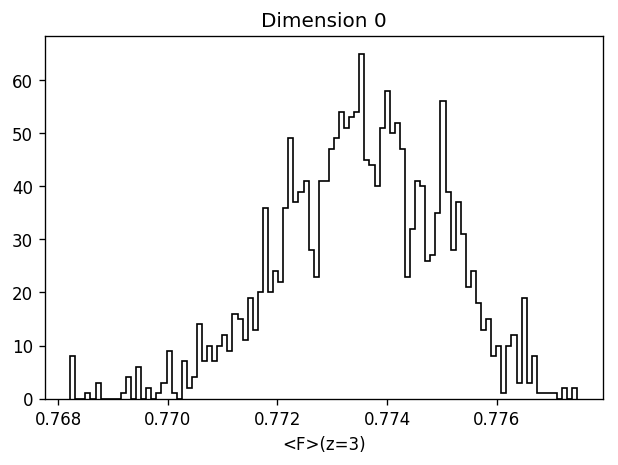

In [18]:
for i in range(ndim):
    plt.figure()
    mf=np.exp(-np.exp(xmin+sampler.flatchain[:,i]*(xmax-xmin)))
    plt.hist(mf, 100, color="k", histtype="step")
    plt.xlabel('<F>(z=3)')
    plt.title("Dimension {0:d}".format(i))

In [19]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.794


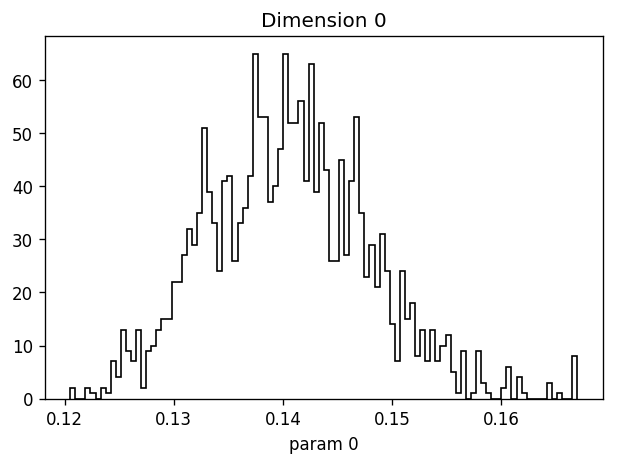

In [20]:
for i in range(ndim):
    plt.figure()
    plt.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    plt.xlabel('param 0')
    plt.title("Dimension {0:d}".format(i))

In [21]:
# get best fit model
ind = np.unravel_index(np.argmax(sampler.lnprobability, axis=None), sampler.lnprobability.shape)
best_fit=sampler.chain[ind]

In [23]:
like.theory.mf_model_fid.get_mean_flux(z=3)

0.7008566448301624

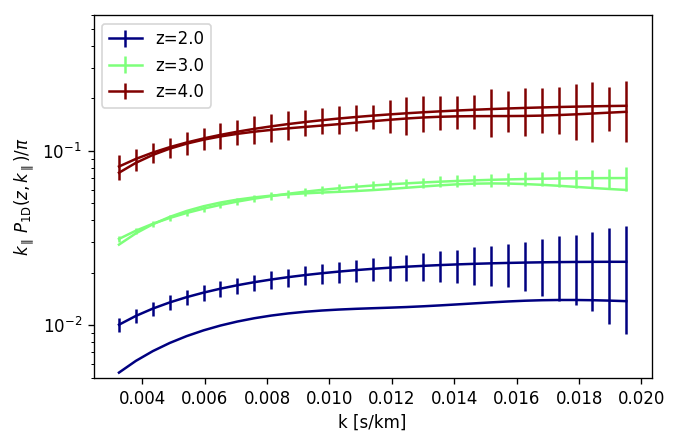

In [22]:
like.plot_p1d(plot_every_iz=1,values=best_fit)